In [1]:
import numpy as np
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt
import numba
from scipy import interpolate


# Aiyagari Model with Aggregate Uncertainty

$$
\max_{\left\{c_t, a_{t+1}\right\}_{t=0}^\infty} \mathbb{E}_t \left[\sum_{t=0}^{\infty} \beta^t \ln c_t\right]
$$
subject to: 

$$
 c_t + k_{t+1}\leq r_t k_t + w l_t + (1 - \delta) k_t ,\ \forall t
$$
 where $ \mathbb{L} = \{0,1\}$
 
and the natural borrowing limit
$$
a_{t}\geq - b,\ \forall t
$$
Note that 
$$\min_{\mathbb{L}} l_{t} = 0 ,\ \forall t$$

so that the natural debt limit is 0 for all consumers. 

The Bellman equation for this problem is:

$$
V(l,a) = \max_{c,a'} \left[ \frac{c^{1- \sigma}}{1-\sigma} + \beta \sum_{l' \in \mathbb{L}}  V(l',a') \Pi(l' | l) \right]
$$ 
subject to:
$$
 c + a' = (1+r) a + w l
$$
$$
a'\geq - b
$$

In [2]:
β  = 0.99
α  = 0.36
δ  = 0.025

# Aggregate and idiosyncratic shocks
Z  = np.array([1.01, 0.99])
π  = np.array([[1/8, 7/8], [7/8, 1/8]])
L  = np.array([1, 0])
# Π  = np.array([[0.8507, 0.1229, 7/12, 3/32],
#               [0.1159, 0.8361, 1/32, 7/20],
#               [0.0243, 0.0021, 7/24, 1/32],
#               [0.0091, 0.0389, 3/32, 21/40]])
Π  = np.array([[[0.8507, 0.1159, 0.0243, 0.0091],[0.1229, 0.8361, 0.0021, 0.0389]],
              [[7/12, 1/32, 7/24, 3/32],[3/32, 7/20, 1/32, 21/40]]])

#Unemployment levels conditional on aggregate state
U = np.array([.04, 0.1])

lstar = 1 - U
kstar = ( (1/β - 1+δ) /(α*(lstar)**(1-α))) ** (1 / (α - 1))
# print(kstar)

@numba.njit
def labor(z):
    if z > 1:
        return 1 - 0.04
    else:
        return 1 - 0.1

@numba.njit
def f(K, z):
    Lsupply = labor(z)
    return z * K**α * Lsupply**(1 - α)

@numba.njit
def mpk(K, z):
    Lsupply = labor(z)
    return α * z *(Lsupply/K)**(1-α) - δ

@numba.njit
def util(c):
        return np.log(max(c, 1E-10))
    
# @numba.njit
# def K_D(r, z):
#     return (α/(r + δ))**(1/(1-α)) * lstar

@numba.njit
def wage(K, z):
    Lsupply = labor(z)
    return (1 - α) * z * (K/Lsupply) ** α

@numba.njit
def K_LOM(alpha, beta, K):
    return alpha + beta * np.log(K)



In [3]:
def build_grid(Nk, NK, klbar=0, kubar=100, Klbar=10, Kubar=80):
    grid = np.linspace(Klbar, Kubar, NK)
    K = np.repeat(grid[:, np.newaxis], 2, axis=1)
    k = klbar + np.divide(np.linspace(0, 0.5, Nk),0.5)**7 * (kubar - klbar)
    k = np.repeat(k[:, np.newaxis], 8, axis=1)
    k = np.repeat(k[:, :, np.newaxis], 2, axis=2)
    k = np.repeat(k[:, :, :, np.newaxis], 2, axis=3)
    return K, k

K, k = build_grid(101, 8)


In [5]:
#Initial guess law of motion for capital
alpha_guess     = np.array([0, 0])
beta_guess      = np.array([1 , 1])
test = alpha_guess + beta_guess * np.log(K)
# print(alpha_g)

## Solving step 2: Finding the policy functions

### Deriving the Euler equation and household budget constraint

The euler equation is given by:

$$
u'(c(k,K,s,z)) = \beta \mathbb{E}_{s,z} \left(f_k(K_+, L_+, z_+) \ u'\left[c(k_+(k, K, s, z),K_+,s_+,z_+) \right] \right)
$$

and the budget constraint is:

$$
 c + k_+\leq r(K,L,z) k + w(K,L,z) l(s) + (1 - \delta) k ,\ \forall t
$$

Abstracting from L and z, our guess gives us $k_+(k,K)$, a function of individual and aggregate capital. Fitting a bivariate spline over k and K we know have an approximation function $g(k, K)$ for any point on the grid. Iterating forward the approximate policy function we get $k_{++}(k_{+}, K_{+}) = g(g(k, K), K_+(K))$. Note that $K_+(K) = \alpha + \beta K$ is not a free element. It is pinned downed by the choice of K the period before. Only k is chosen on the grid by the agent.

In [6]:
#Fit bivariate spline over all states. 
def multispline(k, K, Y):

    tck = []
    for il, li in enumerate(L):
        tckiz = []
        for iz, zi in enumerate(Z):
            tckiz.append(interpolate.RectBivariateSpline(k[:,0,0,0], K[:,iz], Y[:,:,il,iz]))
        tck.append(tckiz)

    return tck



#Evaluate the spline over all states
def multispline_eval(kplus, Kplus, tck):

    output = np.empty((len(k), len(K), len(L), len(Z)))
    for iK, Ki in enumerate(Kplus):
        for il, li in enumerate(L):
            for iz, zi in enumerate(Z):
                output[:,iK,il,iz] =  tck[il][iz](kplus[:,iK,il,iz], Kplus[iK,iz]).flatten() # For a given K and so a given Kprime

    return output



In [50]:
@numba.njit
def BC(w, r, L, kplus, kpplus):
    income = L*w + (1 + r - δ)*kplus
    c  = max(income - kpplus, 10E-10)
    return c

@numba.njit
def BCK(w, r, L, c, k):
    income = L*w + (1 + r - δ)*k
    kup  = max(income - c, 10E-10)
    return kup

@numba.njit
def Euler(kplus, kpplus, Kplus, transition):
    
    index = 0
    income = np.empty((len(L)*len(Z),1))
    cplus = np.empty_like(income)
    Uplus = np.empty_like(income)
    
    for indexL, L_curr in enumerate(L):

        for indexZ, Z_curr in enumerate(Z):

            wplus = wage(Kplus, Z_curr)
            rplus = mpk(Kplus, Z_curr)
            cplus[index,0]  = BC(wplus, rplus, L_curr, kplus, kpplus[indexL, indexZ]) #Budget constraint tomorrow
            Uplus[index,0]  = cplus[index,0]/(1+rplus-δ)
            
            index = index + 1
    
    
    # Get consumption from Euler
    expectedU = transition.T @ Uplus
    euler = expectedU / β
    return euler




# @numba.njit
def backward_iterate_II(kplus, k, K, alpha_guess, beta_guess):
    # init
    kpplus = np.empty_like(kplus)
    cendog = np.empty_like(kplus)
    kendog = np.empty_like(kplus)
    cplus  = np.empty_like(kplus)
    
    #Using aggregate law of motion
    Kplus  = np.exp(alpha_guess + beta_guess * np.log(K))
    # restrict Kplus to fall into bounds
#     Kplus = np.minimum(Kplus, 80)
#     Kplus = np.maximum(Kplus, 10)
#     print(Kplus)
    
    # Use policy function to get K''
    
    tck = multispline(k, K, kplus)
#     print(kpplus)
    kpplus = multispline_eval(kplus, Kplus, tck)

    # Use BC tomorrow, Euler today and BC today to get back policy func
    for iZ, Z_cur in enumerate(Z):
        
        for iK, K_cur in enumerate(K[:,iZ]):

            w = wage(K_cur, Z_cur)
            r = mpk(K_cur, Z_cur)
            
            #Compute possible future incomes
            for iL, L_cur in enumerate(L):

                for ik, k_cur in enumerate(k[:,0,0,0]):
                    transition   = Π[iL][iZ][:, np.newaxis]
                    cendog[ik, iK, iL, iZ]   = Euler(kplus[ik, iK, iL, iZ], kpplus[ik, iK, :, :], Kplus[iK, iZ], transition)  # Euler equation today
                    kendog[ik, iK, iL, iZ]   = BCK(w, r, L_cur, cendog[ik, iK, iL, iZ], k_cur) # Budget constraint today lower bar = 0, upper bar to define

    return kendog


In [81]:
def ss_policy_II(k, K, alpha_guess, beta_guess):
    
    kplus = 0.9*k
    knew = np.empty_like(kplus)
    
    for it in range(3000):
#         print("Iteration number:", it)
        knew = backward_iterate_II(kplus, k, K, alpha_guess, beta_guess)
        if knew is None:
            print("Did not converge", knew)
            break
#         print(np.linalg.norm(knew - kplus))
#         print(np.linalg.norm(knew - kplus))
        if it % 10 == 1 and  np.linalg.norm(knew - kplus) < 1E-5:
            print(f'convergence in {it} iterations!')
            tck_out = multispline(k, K, knew)
            return tck_out
        
        kplus = 0.4*knew + 0.6*kplus
    

In [23]:
%time tck = ss_policy_II(k, K, alpha_guess, beta_guess)

convergence in 531 iterations!
CPU times: user 9.01 s, sys: 3.97 ms, total: 9.01 s
Wall time: 9.02 s


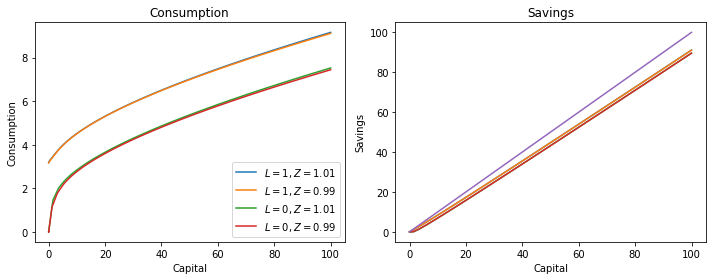

In [24]:
savings = multispline_eval(k, K, tck)


def savings_to_c(savings, k, K, tck):
    c       = np.empty_like(savings)
    for iL, L_curr in enumerate(L):
        for iZ, Z_curr in enumerate(Z):
            for iK, K_cur in enumerate(K[:,iZ]):
                for ik, k_cur in enumerate(k[:,0,0,0]):
                    c[ik, iK, iL, iZ] = BC(wage(K_cur, Z_curr), mpk(K_cur, Z_curr), L_curr, k_cur, savings[ik, iK, iL, iZ])
    return c

c = savings_to_c(savings, k, K, tck)
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title('Consumption')
ax2.set_title('Savings')
for iL, L_curr in enumerate(L):
    for iZ, Z_curr in enumerate(Z):
        ax1.plot(k[:,0,0,0], c[:,7, iL, iZ], label=r'$L = {j}, Z= {i} $'.format(j=L_curr, i=Z_curr))
        ax2.plot(k[:,0,0,0], savings[:,7, iL, iZ])
ax2.plot(k[:,0,0,0], k[:,0,0,0])
ax1.legend()
ax1.set(xlabel="Capital", ylabel="Consumption")
ax2.set(xlabel="Capital", ylabel="Savings")
plt.tight_layout()

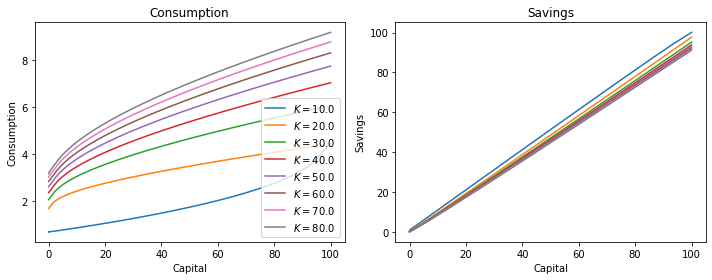

In [25]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title('Consumption')
ax2.set_title('Savings')
for iK, K_cur in enumerate(K[:,0]):
        ax1.plot(k[:,0,0,0], c[:,iK, 0, 0], label=r'$K = {j}$'.format(j=K_cur))
        ax2.plot(k[:,0,0,0], savings[:,iK, 0, 0])

ax1.legend()
ax1.set(xlabel="Capital", ylabel="Consumption")
ax2.set(xlabel="Capital", ylabel="Savings")
plt.tight_layout()

## Solve the model

### Draw random aggregate and idiosyncratic shocks to simulate aggregate economy

In [26]:
@numba.njit
def update(iz):
    # then do random draw for the state
    iz_plus = 1 - np.random.binomial(1, π[1,iz])
    return iz_plus

@numba.njit
def update_idio(il, iz, iz_plus):
    # then do random draw for the state
    transition = Π[il][iz]         #Select states today and proba of healthy tomorrow
    P = transition[iz_plus]
    Pc = transition[iz_plus + 2]
    norm = np.sum(transition)
    P = P/(P+Pc)
    
#     print(transition)
    #     print("Proba employed", transition[iz_plus])
    il_plus = 1 - np.random.binomial(1, P)

    return il_plus

# @numba.njit
def simu_agg(tck, k, K0, izstart=0, T=1100, T_drop=100):
    z_t       = np.empty(T, dtype=int)
    z_t[0]    = izstart
#     z_t       = np.zeros(T, dtype=int)
    K_t       = np.empty(T)
    K_t[0]    = K0
    kplus     = np.empty_like(k)
    l         = np.zeros_like(k, dtype=int)
    draw = np.random.uniform(size=len(k))
    l = (draw > 0.9)*1
   
    np.random.seed(0)
        
    for t in range(T-1):

        z_t[t+1] = update(z_t[t])

        for ik, k_cur in enumerate(k):

            policy = tck[l[ik]][z_t[t]]
            kplus[ik]  = policy(k[ik], K_t[t])

#             print("Status today", 1 - l[ik])
            l[ik] = update_idio(l[ik], z_t[t], z_t[t+1])
#             print("Status tomorrow", 1 - l[ik])
#         print(kplus)
        K_t[t+1] = np.average(kplus)
        k = kplus
#         print(l)
    print("Average employment status", np.average(1-l)) 
    #trim data
    K_t = K_t[T_drop:]
    z_t = z_t[T_drop:]    
    # return averages
    print("Average State of the economy",np.average((1-z_t)))
          
    return K_t, z_t

distrib = np.linspace(0,100,10)
K_t, z_t = simu_agg(tck, distrib, 30)
# update(0)
print(np.average(K_t))

Average employment status 0.9
Average State of the economy 0.45
14.468056237304216


### update aggregate law of motion

In [28]:
@numba.njit
def regression(x,y):
    X = np.empty((len(x),2))
    c  = np.ones_like(x)
    X[:,0]  = c
    X[:,1]  = np.log(x)
    Y       = np.log(y)
    beta = np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y.T))
    slope = beta[1]
#     print(slope)
    intercept = beta[0]
    return slope, intercept


    
# @numba.njit
def param_update(K_t, z_t):
    Ksub = K_t[:len(K_t)-1]
    zsub = z_t[:len(K_t)-1]
    Kb = Ksub[zsub == 1]
    Kg = Ksub[zsub == 0]
    
    Kbplus = K_t[np.array(np.where(zsub == 1)) + 1]
    Kgplus = K_t[np.array(np.where(zsub == 0)) + 1]
    
    betab, alphab = regression(Kb, Kbplus)
    betag, alphag = regression(Kg, Kgplus)
    
    alpha = np.array([alphag, alphab])
    beta = np.array([betag, betab])
    
    return alpha.T, beta.T

## Iterate over aggregate law of motion

In [82]:
def solve_ks(k, K):
    
    alpha_guess     = np.array([0,  0])
    beta_guess      = np.array([0.9, 0.97])
    distrib = np.ones(10000)*40 # initial distribution of individual
    
    for it in range(1000):
#         print("Iteration number:", it)
        print("Alpha",alpha_guess)
        print("Beta",beta_guess)
        tck = ss_policy_II(k, K, alpha_guess, beta_guess)
        if tck is None:
            print("Did not converge!")
            break
        K_t, z_t = simu_agg(tck, distrib, 40)
        print("Kss", np.average(K_t))
        alpha, beta = param_update(K_t, z_t)

        err = np.linalg.norm(np.array([alpha, beta]) - np.array([alpha_guess, beta_guess]))
        print("Parameter updating error", err)
        if it % 10 == 1 and err  < 0.04:
            print(f'convergence in {it} iterations!')
            
            return alpha, beta, tck, K_t, z_t
        
        alpha_guess = 0.5*alpha + 0.5*alpha_guess
        beta_guess  = 0.5*beta  + 0.5*beta_guess
    

In [83]:
alpha, beta, tck, K_t, z_t = solve_ks(k, K)

Alpha [0 0]
Beta [0.9  0.97]
convergence in 291 iterations!
Average employment status 0.9611
Average State of the economy 0.515
Kss 15.015062158073837
Parameter updating error 1.7295564213910153
Alpha [[0.08928912 0.08065413]]
Beta [[0.91735183 0.95490325]]
convergence in 421 iterations!
Average employment status 0.9606
Average State of the economy 0.533
Kss 19.637746467918404
Parameter updating error 0.09670248125624968
Alpha [[0.12175338 0.11273718]]
Beta [[0.93315409 0.95269412]]
convergence in 711 iterations!
Average employment status 0.9564
Average State of the economy 0.466
Kss 26.23467455998264
Parameter updating error 0.050429862905832366
Alpha [[0.13866631 0.12848134]]
Beta [[0.94317131 0.95392788]]
convergence in 981 iterations!
Average employment status 0.9017
Average State of the economy 0.564
Kss 28.1502698609781
Parameter updating error 0.048671801049311667
Alpha [[0.15715228 0.14407105]]
Beta [[0.94558097 0.95263965]]
convergence in 441 iterations!
Average employment sta

In [84]:
def simu_approx(K0, alpha, beta, z_t):
    simuK = np.zeros(len(z_t))
    simuK[0] = K0
    for t in range(len(z_t) - 1):

        simuK[t+1] = np.exp(alpha[0,z_t[t]] + beta[0, z_t[t]]*np.log(simuK[t]))
    return simuK

simuK = simu_approx(K_t[0], alpha, beta, z_t)

                       

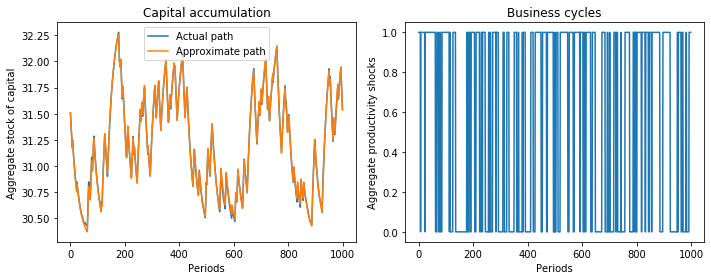

In [85]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title('Capital accumulation')
ax2.set_title('Business cycles')
ax1.plot(K_t, label="Actual path")
ax1.plot(simuK, label= "Approximate path")
ax2.plot(z_t)
ax1.legend()
ax1.set(xlabel="Periods", ylabel="Aggregate stock of capital")
ax2.set(xlabel="Periods", ylabel="Aggregate productivity shocks")
plt.tight_layout()

In [86]:
alpha

array([[0.15979124, 0.15106021]])

In [87]:
beta

array([[0.95409771, 0.95570399]])